In [62]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [63]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [64]:
std_transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307), (0.3081)), # mean and standard deviation
  AddGaussianNoise(0., 0.6),
])

In [65]:
train_ds = torchvision.datasets.MNIST(root='downloads', train=True, download=True, transform = std_transform)
valid_ds = torchvision.datasets.MNIST(root='downloads', train=False, download=True, transform = std_transform)

In [66]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle = True, drop_last = True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=512, shuffle = True, drop_last = True)

Truth: tensor(0)
tensor(-2.1836)


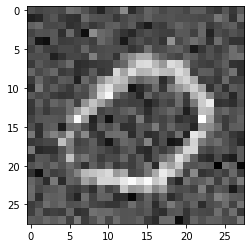

In [67]:
def print_imgs(model=None):
    if (model):
      plt.imshow(model(torch.randn(512, 128).cuda()).cpu().detach()[0,0], cmap='gray')
    else:
      data, label = next(iter(train_loader))
      print("Truth:", label[0])
      plt.imshow(data[0,0], cmap='gray')
print_imgs()
data, label = next(iter(train_loader))
print(torch.min(data[0]))

In [95]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(28 * 28, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 10),
        torch.nn.Softmax(),
    )
  def forward(self, x):
    x = self.layers(x)
    return x

In [96]:
model = Net().cuda()
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
cross_entropy = torch.nn.CrossEntropyLoss().cuda()

epochs = 3

In [97]:
def test(model, test_loader, cross_entropy):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            predict = cross_entropy(output.log(), target)
            test_loss += predict.item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [102]:
epochs = 10
# Lo entrene un ratito y tira a 87% con ruido con desviacion 0.4
for i in range(epochs):
  for batch_idx, (data, label) in enumerate(train_loader):
      data, label = data.cuda(), label.cuda()

      optim.zero_grad()
        
      predictions = model(data)
      loss = cross_entropy(predictions, label)
        
      loss.backward()
      optim.step()
  test(model, valid_loader, cross_entropy)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: ignored